# Final Project

Info 4609

Michael Murdock

## Vehicle Detection Classification on Images

I will be classifying images as vehicles or non-vehicles, using the vehicle image dataset from kaggle. First, I will load in the data in its original form, as well as its resized form for comparison. Next, I'll inspect images before and after resizing, to understand how the pixel adjustment affects the image and is computationally more efficient. After, I will split the original and resized data into training and testing sets in order to build decision trees for both forms of data. Before fitting the data to our model, I'll be reshaping it from its 4 dimensional representation to a 2 dimensional representation. This will provide compatability with Decision Trees and Random Forest Classifiers, as they both require a 2 dimensional input. Once the data is properly split and reshaped, I will train several decision trees using various test parameters to identify the best performing tree. The parameters which enable the best performing tree will be employed in the RFC at different estimators to combine trees and maximize accuracy. I'll then move on to the tensorflow implementation, where I read in the data directory using tensorflows built-in methods and associated modules for automatic preprocessing. Next, I'll build the sequential model, specifically a convolutional neural network with a layer for Conv2d to create a convolutional kernel, followed by a flatten layer to flatten multi-dimensional input into a single dimension, and finally 3 dense layers to reduce the dimensonality of the output until binary. I'll then fit both the preprocessed data and train datasets previously used in the decision tree and RFC, in order to compare and contrast results. Finally I'll evaluate both models through plotting accuracy and losses, as well the models predictions on a subset of images in the dataset. Here I will also take an image of my own car, read it in and process with cv2 (since plt.imread identifies the inherent extension) and classify the unseen image with both of my models. 

# Overview

- [Set Up](#Set-Up)
  - [Import Packages](#Import-Packages)
  - [Check Working Dir](#Check-Working-Dir)
  - [Colab Kaggle Data Import Steps](#Colab-Kaggle-Data-Import-Steps)
- [Import and Prepare Images](#Import-and-Prepare-Data)
  - [Load and Label Data](#Load-and-Label-Data)
  - [Read Images without Resizing](#Read-Images-without-Resizing)
  - [Read and Resize Images for Comparison](#Read-and-Resize-Images-for-Comparison)
  - [View Images Before and After Resizing](#View-Images-Before-and-After-Resizing)
- [Decision Tree and RFC Implementation](#Decision-Tree-and-RFC-Implementation)
  - [Split and Inspect](#Split-and-Inspect)
  - [Reshape from 4d to 2d](#Reshape-from-4d-to-2d)
  - [Instantiate and Train Decision Tree](#Instantiate-and-Train-Decision-Tree)
  - [Plot-Accuracies-and-Best-Performing-Tree](#Plot-Accuracies-and-Best-Performing-Tree)
  - [Instantiate and Train Random Forest](#Instantiate-and-Train-Random-Forest)
  - [Evaluate RFC](#Evaluate-RFC)
     - [Plot Train and Test Accuracies](#Plot-Train-and-Test-Accuracies)
     - [Plot Predictions with RFC](#Plot-Predictions-with-RFC)
     - [Classify My Car with RFC](#Classify-My-Car-with-RFC)
      
- [Tensorflow Implentation](#Tensorflow-Implentation)
  - [Generate Batches of Augmented Data with Keras Preprocessing Methods](#Generate-Batches-of-Augmented-Data-with-Keras-Preprocessing-Methods)
  - [Build and Compile Sequential Model](#Build-and-Compile-Sequential-Model)
  - [Fit Model with Augmented Data](#Fit-Model-with-Augmented-Data)
  - [Fit Model with cv2 Preprocessed Data](#Fit-Model-with-cv2-Preprocessed-Data)
  - [Evaluate CNN](#Evaluate-CNN)
    - [Plot Predictions with CNN](#Plot-Predictions-with-CNN)
    - [Plot CNN Accuracy and Loss](#Plot-CNN-Accuracy-and-Loss)
    - [Predict my Car with CNN](#Predict-my-Car-with-CNN)

# Set Up

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import time

import matplotlib.pyplot as plt
import seaborn as sb
from skimage.transform import resize

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Init Plugin
Init Graph Optimizer
Init Kernel


### Check Working Dir

In [2]:
os.getcwd()

'/Users/michaelm/Dropbox/INFO4604/Final Project'

### Colab Kaggle Data Download Steps

- Steps only required for importing data into Colabs content folder in Google Drive if tensorflow is not installed locally

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d brsdincer/vehicle-detection-image-set
! unzip vehicle-detection-image-set.zip

mkdir: /Users/michaelm/.kaggle: File exists
cp: kaggle.json: No such file or directory
zsh:1: command not found: kaggle
unzip:  cannot find or open vehicle-detection-image-set.zip, vehicle-detection-image-set.zip.zip or vehicle-detection-image-set.zip.ZIP.


# Import and Prepare Images

### Load and Label Data

In [4]:
labs, rel_paths, clabs = np.array([]), [], ''

# iterate through paths in data directory
for data in os.walk('data'):
    # If dir is not the data/ directory
    if data[0] != 'data':
        # Get dir name (vehicle or non-vehicle)
        clabs = data[0].split('/')[1]
    # iterate through files in dirs
    for file_ in data[2]:
        # append label to array
        labs = np.append(labs, np.where(clabs == 'vehicles', 1, 0)).astype(int)
        # append relative file path
        rel_paths.append(f'{data[0]}/{file_}')

# store in df and shuffle
df_shuffled = pd.DataFrame(
    {'paths': rel_paths, 'labels': labs}).sample(
        frac=1, random_state=123).reset_index()

df_shuffled.head()

,index,paths,labels
0,10079,data/vehicles/366.png,1
1,5914,data/non-vehicles/extra5005.png,0
2,10361,data/vehicles/right (219).png,1
3,15977,data/vehicles/43.png,1
4,5379,data/non-vehicles/extra3465.png,0


### Read Images without Resizing

In [5]:
# Use CV2 to read in images
labels = df_shuffled['labels']
images = np.array([cv2.imread(p) for p in df_shuffled['paths']])
print(f'Images: \nshape - {images.shape}, size - {images.size}')

Images: 
shape - (17760, 64, 64, 3), size - 218234880


### Read and Resize Images for Comparison

In [6]:
# Use CV2 to read in and resize images
resized_images = np.array([cv2.resize(cv2.imread(p), (32, 32))
                          for p in df_shuffled['paths']])
print('Resized Images: \nshape - '
      f'{resized_images.shape}, size - {resized_images.size}')

# Reading in with plt seems slightly slower
# resize = np.array([resize(plt.imread(p), (32,32,3)) for p in df_shuffled['paths']])

Resized Images: 
shape - (17760, 32, 32, 3), size - 54558720


### View Images Before and After Resizing

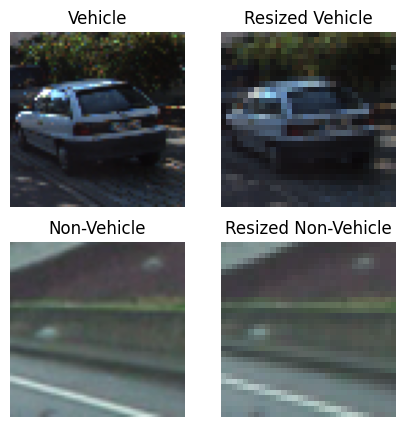

In [7]:
def label(df, r):
    """Labels an instance categorically"""
    return np.where(df['labels'][r] == 1, 'Vehicle', 'Non-Vehicle')


def compare_resized(df, r, r2):
    """Plots a vehicle and non-vehicle before and after resizing"""
    # Set fig
    f, (ax, ax1) = plt.subplots(2, 2, figsize=(5, 5))

    # Label instances
    rlab, rlab2 = label(df, r), label(df, r2)

    # Plot before/after resizing
    # Vehicle
    ax[0].imshow(plt.imread(df['paths'][r]))
    ax[1].imshow(np.array(resize(plt.imread(df['paths'][r]), (32, 32, 3))))
    ax[0].set_title(rlab), ax[1].set_title(f'Resized {rlab}')
    ax[0].set_axis_off(), ax[1].set_axis_off()

    # Non-vehicle
    ax1[0].imshow(plt.imread(df['paths'][r2]))
    ax1[1].imshow(np.array(resize(plt.imread(df['paths'][r2]), (32, 32, 3))))
    ax1[0].set_title(rlab2), ax1[1].set_title(f'Resized {rlab2}')
    ax1[0].set_axis_off(), ax1[1].set_axis_off()


compare_resized(df_shuffled, 15, 25)

# Decision Tree and RFC Implementation


- Will be testing different accuracies for decision trees at various depth and sample leafs. 
- Best decision tree performance will be employed in the Random Forest Classifier and tested at various estimators
- Accuracy and loss will be compared between the RFC model and CNN

### Split and Inspect

In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.25)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Resized data
Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(
    resized_images, labels, test_size=0.25)

print(Xtrain_res.shape, Xtest_res.shape, ytrain_res.shape, ytest_res.shape)

(13320, 64, 64, 3) (4440, 64, 64, 3) (13320,) (4440,)
(13320, 32, 32, 3) (4440, 32, 32, 3) (13320,) (4440,)


### Reshape from 4d to 2d

In [9]:
# Reshaping for compatability with decision tree

def reshape_4d_to_2d(train, test):
    """Reshapes a 4 dimensional array to 2 dimensional"""
    # Get shape dimensions
    nsamples, nx, ny, nz = train.shape
    nsamples_, nx_, ny_, nz_ = test.shape

    # Reshape
    d2_Xtrain = train.reshape((nsamples, nx*ny*nz))
    d2_Xtest = test.reshape((nsamples_, nx_*ny_*nz_))

    return d2_Xtrain, d2_Xtest

# Reshape data
d2_Xtrain, d2_Xtest = reshape_4d_to_2d(X_train, X_test)
print(d2_Xtrain.shape, d2_Xtest.shape)

# Reshape resized data
d2Xtrain_res, d2Xtest_res = reshape_4d_to_2d(Xtrain_res, Xtest_res)
print(d2Xtrain_res.shape, d2Xtest_res.shape)

(13320, 12288) (4440, 12288)
(13320, 3072) (4440, 3072)


### Instantiate and Train Decision Tree

- This cell takes a while to run. The RFC below employs the best parameters, so cell is not necessary to run.

In [10]:
# Will do this with resized data as well

# Set depths/leafs
max_depths = [3, 8, 14, 100]
min_leafs = [1, 5, 10, 15, 50]


training = []
testing = []
depths = []
leafs = []

# Loop through depths and leafs
for m in max_depths:
    for j in min_leafs:

        # Instantiate and fit model
        tree_model = DecisionTreeClassifier(
            criterion='gini', max_depth=m, min_samples_leaf=j, random_state=123)
        tree_model.fit(d2_Xtrain, y_train)

        # Evaluate
        test_predictions = tree_model.predict(d2_Xtest)
        train_predictions = tree_model.predict(d2_Xtrain)

        # Appends
        training.append(accuracy_score(train_predictions, y_train))
        testing.append(accuracy_score(test_predictions, y_test))
        depths.append(m), leafs.append(j)

        print(f'Model trained at {m} depths and {j} leafs')

# Create df for tree models metrics
trees_df = pd.DataFrame({'train_acc': training, 'test_acc': testing,
                    'max_depth': depths, 'min_samples': leafs})

Model trained at 3 depths and 1 leafs
Model trained at 3 depths and 5 leafs
Model trained at 3 depths and 10 leafs
Model trained at 3 depths and 15 leafs
Model trained at 3 depths and 50 leafs
Model trained at 8 depths and 1 leafs
Model trained at 8 depths and 5 leafs
Model trained at 8 depths and 10 leafs
Model trained at 8 depths and 15 leafs
Model trained at 8 depths and 50 leafs
Model trained at 14 depths and 1 leafs
Model trained at 14 depths and 5 leafs
Model trained at 14 depths and 10 leafs
Model trained at 14 depths and 15 leafs
Model trained at 14 depths and 50 leafs
Model trained at 100 depths and 1 leafs
Model trained at 100 depths and 5 leafs
Model trained at 100 depths and 10 leafs
Model trained at 100 depths and 15 leafs
Model trained at 100 depths and 50 leafs


In [11]:
# View df and row with highest test acc
display(trees_df)
trees_df.loc[trees_df.test_acc.idxmax()]

,train_acc,test_acc,max_depth,min_samples
0,0.842568,0.832883,3,1
1,0.842568,0.832883,3,5
2,0.842568,0.832883,3,10
3,0.842568,0.832883,3,15
4,0.842568,0.832883,3,50
5,0.956982,0.908784,8,1
6,0.954204,0.910360,8,5
7,0.948123,0.906081,8,10
8,0.943093,0.906757,8,15
9,0.922523,0.892342,8,50


train_acc       0.991742
test_acc        0.916667
max_depth      14.000000
min_samples     1.000000
Name: 10, dtype: float64

### Plot Accuracies and Best Performing Tree

Text(0, 0.5, 'Test Accuracy')

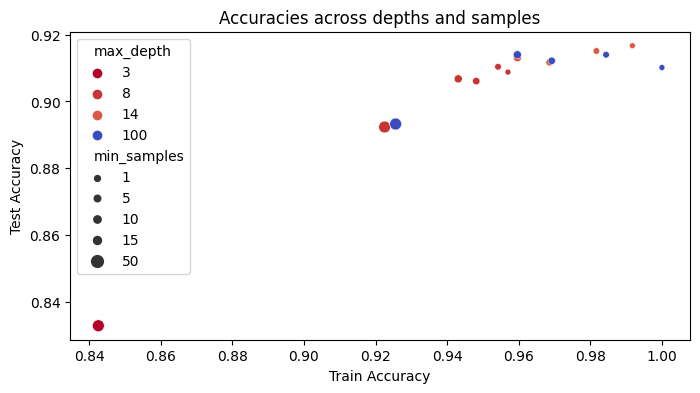

In [12]:
# Set fig
f, ax = plt.subplots(figsize=(8, 4))

# Create scatterplot (size is samples and color is depths)
sb.scatterplot(data=trees_df, x='train_acc', y='test_acc',
               hue='max_depth', size='min_samples', palette='coolwarm_r')

# Set plot elements
plt.title('Accuracies across depths and samples')
plt.xlabel('Train Accuracy')
plt.ylabel('Test Accuracy')

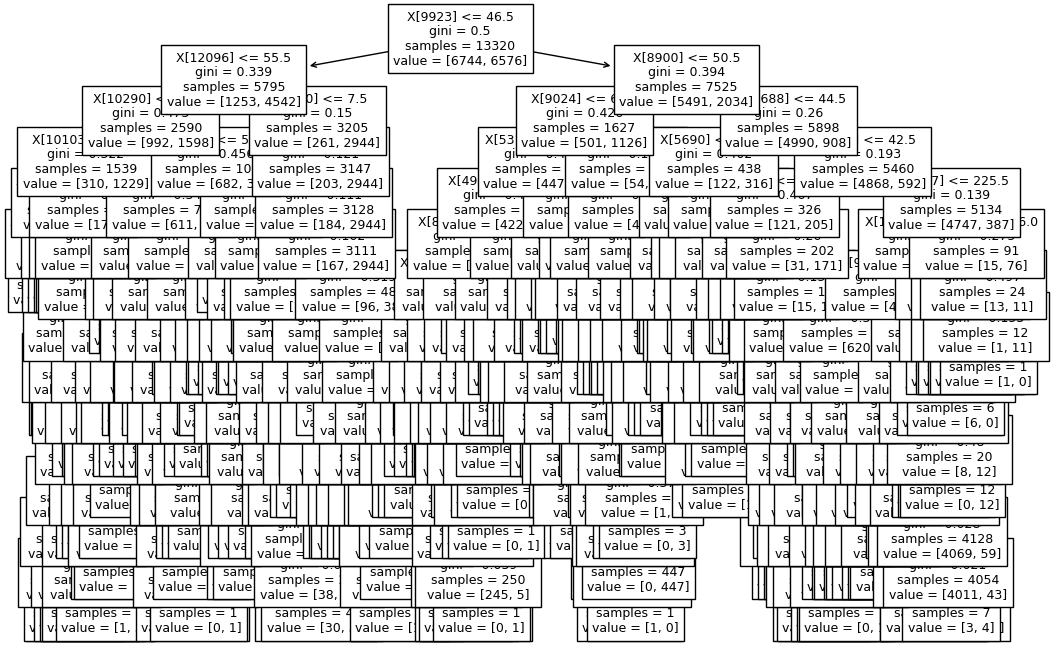

In [13]:
# Set fig (should make larger)
plt.figure(figsize=(12,8))

# Instantiate/fit best tree model
best_model = DecisionTreeClassifier(
    criterion='gini', max_depth=14, min_samples_leaf=1, random_state=123).fit(
    d2_Xtrain, y_train)

# Plot
tree.plot_tree(best_model, fontsize=9)
plt.show()

### Instantiate and Train Random Forest

In [32]:
# Set estimators
estimators = [10, 50, 100, 300]

training = []
testing = []
n_est = []

# Start time
start = time.time()

# Iterate through estimators
for e in estimators:

    # Instantiate/fit model at each estimator
    forest_model = RandomForestClassifier(
        n_estimators=e, max_depth=14, min_samples_leaf=1, random_state=123)
    forest_model.fit(d2_Xtrain, y_train)

    # Evaluate
    test_predictions = forest_model.predict(d2_Xtest)
    train_predictions = forest_model.predict(d2_Xtrain)

    # Appends
    training.append(accuracy_score(train_predictions, y_train))
    testing.append(accuracy_score(test_predictions, y_test))
    n_est.append(e)

    print(f'Model trained at {e} estimators')

# End time
end = time.time()

# Create df for forest model metrics
forest_df = pd.DataFrame(
    {'train_acc': training, 'test_acc': testing, 'n_estimator': n_est})

# Show completion time (min:sec)
print(f'Completion Time: {(end-start)/60:.2f} m')

Model trained at 10 estimators
Model trained at 50 estimators
Model trained at 100 estimators
Model trained at 300 estimators
Completion Time: 4.85 m


In [33]:
# View df and row with highest test acc
display(forest_df)
forest_df.loc[forest_df.test_acc.idxmax()]

,train_acc,test_acc,n_estimator
0,0.989414,0.955405,10
1,0.990916,0.965991,50
2,0.990916,0.967568,100
3,0.991216,0.966667,300


train_acc        0.990916
test_acc         0.967568
n_estimator    100.000000
Name: 2, dtype: float64

## Evaluate RFC

### Plot Train and Test Accuracies

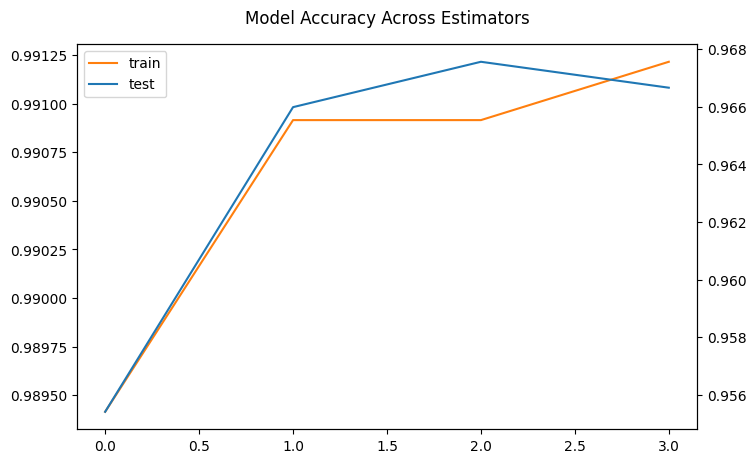

In [34]:
# Set fig
f, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

# Plot train/test acc by estimators
ax.plot(forest_df['train_acc'],label='train', c='tab:orange')
ax2.plot(forest_df['test_acc'], label='test', c='tab:blue')

# Set plot elements
ax.set_title('Model Accuracy Across Estimators', pad=15)
lns, labs = ax.get_legend_handles_labels()
lns2, labs2 = ax2.get_legend_handles_labels()
ax2.legend(lns + lns2, labs + labs2, loc=0)

### Plot Predictions with RFC

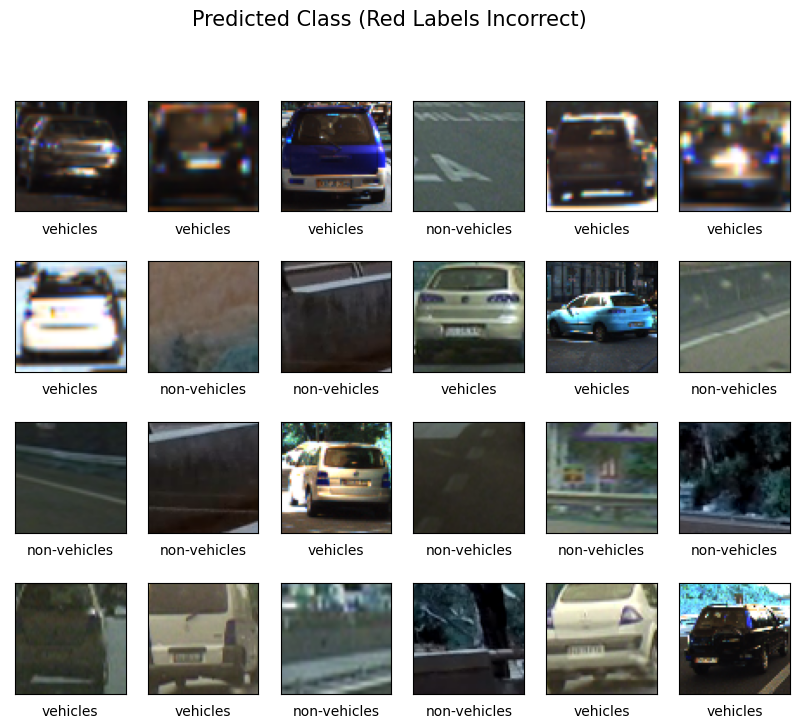

In [19]:
label_dict = {1.: 'vehicles', 0.: 'non-vehicles'}

# Predict testing dataset
y_fit = forest_model.predict(d2_Xtest)


def plot_predictions(xtest, ytest, yfit, samplesr, samplesc):
    """Plot samplesr*samplesc images and label prediction"""
    # Set fig
    f, ax = plt.subplots(samplesr, samplesc, figsize=(10, 8))
    pred_sub = np.array(ytest)

    # Iterate over axes
    for i, axi in enumerate(ax.flat):
        # Plot images
        axi.imshow(xtest[i], cmap='bone')
        axi.set(xticks=[], yticks=[])

        # Label image with model prediction
        axi.set_xlabel(label_dict[yfit[i]],
                       color='black' if yfit[i] == pred_sub[i] else 'red')

    # Set title
    f.suptitle('Predicted Class (Red Labels Incorrect)', size=15)


plot_predictions(X_test, y_test, y_fit, 4, 6)

### Classify My Car with RFC

Predicted: Vehicle


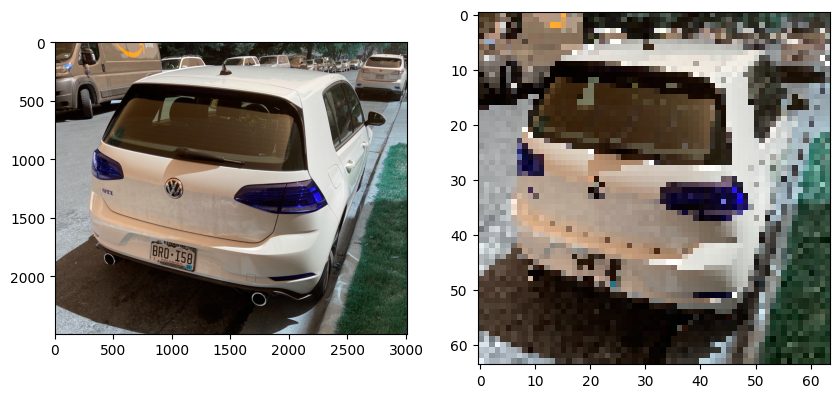

In [20]:
def process_iphone_photo(png):
    """
    Resize, reshape, and plot Iphone images for inspecting and compatability 
    with decision tree model.
    """
    # Set axis
    f, ax = plt.subplots(1, 2, figsize=(10, 6))

    # Resize
    car_image = cv2.resize(cv2.imread(png), (64, 64))

    # Plot image before and after resizing
    ax[0].imshow(cv2.imread(png))
    ax[1].imshow(car_image)

    # Reshape into 2D
    nx, ny, nz = car_image.shape
    shaped_image = car_image.reshape(1, nx*ny*nz)

    return shaped_image


# Process and Classify my Image
my_car = process_iphone_photo('my_car.png')

print('Predicted:', np.where(forest_model.predict(
    my_car), 'Vehicle', 'Non-Vehicle')[0])

# Tensorflow Implentation


Using a convolutional neural network to classify images. Starting with Conv2d layer which performs elementwise multiplication, resulting in a single output pixel. Specifying our input shape as 64 by 64 with a channel of 3 for RGB, and the shape of the convolutional kernel as 3 by 3 with a total of 32 layers.

### Generate Batches of Augmented Data with Keras Preprocessing Methods

In [21]:
# will test both preprocessed and original data

# Create generator
data_gen = ImageDataGenerator(rescale=1/255, validation_split=.25)

# Train generator to Augment data
t_gen = data_gen.flow_from_directory(
    'data',
    class_mode='binary',
    shuffle=True,
    target_size=(64, 64),
    batch_size=64
)

# Validation generator for evaluating model
validator_gen = data_gen.flow_from_directory(
    'data',
    class_mode='binary',
    shuffle=True,
    target_size=(64, 64),
    batch_size=64,
    subset='validation'
)

Found 17760 images belonging to 2 classes.
Found 4440 images belonging to 2 classes.


### Build and Compile Sequential Model

- Conv2d: Using Convolutional 2d layer, learning a total of 32 layers with a 3x3 kernel size (i.e., 2D width and height of the filter). Input shape of (64, 64, 3), which is the dimensions of our image data. This layer essentially transforms our input (image) into an abstract representation that the densely connected layers can then use to generate a classification. Rectified linear activation function (reLU) is used to isolate the features by outputting 0 for negative inputs, indicating the pixel values which are not important. 
- Flatten: Dense layers can only deal with one dimensional data, so we need to convert our multidimensional feature map with the flatten layer in order to get the one dimensional shape required for the dense layers.
- Dense x 3: Multiple dense layers to reduce dimensionality until shape is binary, since our predictions are considered binary classification (Vehicle or Non-Vehicle). ReLU is used in hidden layers primarily for better computational performance and is one of the most commonly used activation functions for hidden layers in CNN. Softmax is used in last dense layer which allows us to generate a probability distribution in order to understand which classification is more likely. The dense layers are the regular deeply connected layers that perform the operation activation(dot(input, kernal) + bias).

In [22]:
def build_sequential():
    '''Builds a Keras Sequential Model and compiles'''
    keras_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(
            64, 64, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # compiling model with adam optimizer and binary crossentropy loss function
    keras_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    return keras_model


keras_model = build_sequential()
keras_model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7872576   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,875,585
Trainable params: 7,875,585
Non-trainable params: 0
_________________________________________________________________


2022-11-14 21:27:14.404299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 21:27:14.404501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Fit Model with Augmented Data

In [23]:
# Fit model usign the train & validator gens
augmented_hist = keras_model.fit(
    t_gen, epochs=20, steps_per_epoch=np.ceil(17746/64),
    validation_data=validator_gen, validation_steps=np.ceil(4440/64), verbose=1)

# avgs 18s per epoch, can speed up if batch size is increased, yet may lose accuracy

2022-11-14 21:27:18.131308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-14 21:27:18.131776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 21:27:18.303960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
278/278 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9337

2022-11-14 21:27:33.234045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 18s 64ms/step - loss: 0.1832 - accuracy: 0.9337 - val_loss: 0.0536 - val_accuracy: 0.9849
Epoch 2/20
278/278 [==============================] - 17s 62ms/step - loss: 0.0643 - accuracy: 0.9787 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 3/20
278/278 [==============================] - 18s 63ms/step - loss: 0.0312 - accuracy: 0.9894 - val_loss: 0.0222 - val_accuracy: 0.9935
Epoch 4/20
278/278 [==============================] - 17s 62ms/step - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.0147 - val_accuracy: 0.9962
Epoch 5/20
278/278 [==============================] - 17s 62ms/step - loss: 0.0166 - accuracy: 0.9943 - val_loss: 0.0070 - val_accuracy: 0.9982
Epoch 6/20
278/278 [==============================] - 17s 62ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0043 - val_accuracy: 0.9986
Epoch 7/20
278/278 [==============================] - 17s 62ms/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 0.0078 - val_accuracy: 0.9980
Epo

### Fit Model with CV2 Preprocessed Data

In [24]:
# Instantiate new model for CV2 data
keras_model2 = build_sequential()

# Fit model with train datasets and define validation data
standard_hist = keras_model2.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),
    steps_per_epoch=np.ceil(17746/64), verbose=1)

Epoch 1/20
  1/278 [..............................] - ETA: 1:26 - loss: 4.5588 - accuracy: 0.5625

2022-11-14 21:33:05.038518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - ETA: 0s - loss: 15.4447 - accuracy: 0.8900

2022-11-14 21:33:19.516415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 21s 74ms/step - loss: 15.4447 - accuracy: 0.8900 - val_loss: 0.7213 - val_accuracy: 0.9245
Epoch 2/20
278/278 [==============================] - 20s 73ms/step - loss: 0.2061 - accuracy: 0.9726 - val_loss: 0.2589 - val_accuracy: 0.9550
Epoch 3/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0644 - accuracy: 0.9854 - val_loss: 0.1255 - val_accuracy: 0.9786
Epoch 4/20
278/278 [==============================] - 21s 74ms/step - loss: 0.0374 - accuracy: 0.9911 - val_loss: 0.1164 - val_accuracy: 0.9813
Epoch 5/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0439 - accuracy: 0.9904 - val_loss: 0.1628 - val_accuracy: 0.9755
Epoch 6/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0385 - accuracy: 0.9901 - val_loss: 0.1707 - val_accuracy: 0.9786
Epoch 7/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0582 - accuracy: 0.9884 - val_loss: 0.3991 - val_accuracy: 0.9669
Ep

# Evaluate CNN

## Augmented Data

### Plot Predictions with CNN

2022-11-14 21:39:49.701605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


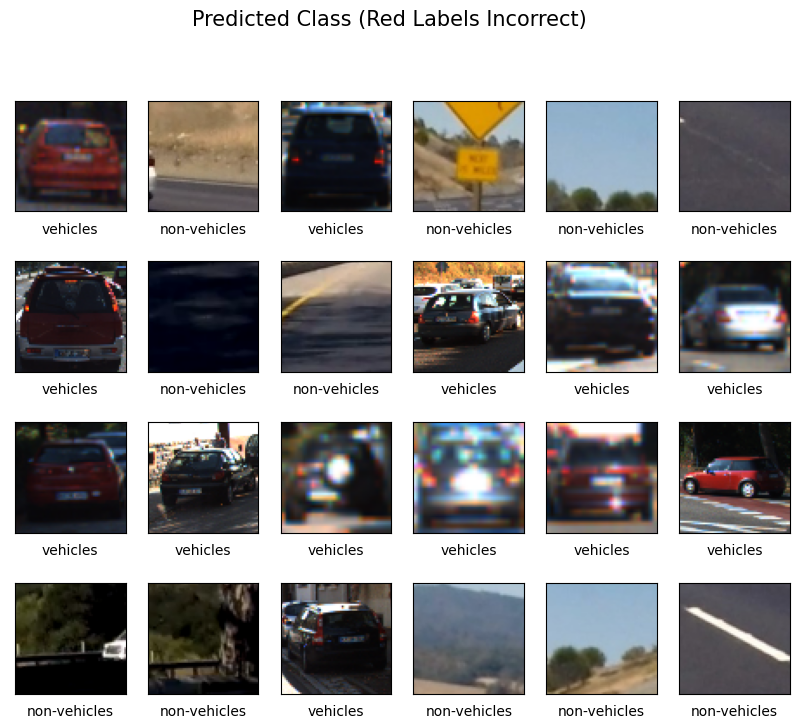

In [25]:
# get x_test and y_test
xt, yt = validator_gen.next()

# Predict with CNN
y_fit_tgen = keras_model.predict(xt)

# Convert value to int for classifying
yf = [int(i) for i in y_fit_tgen]

# Plot predictions
plot_predictions(xt, yt, yf, 4, 6)

### Plot Accuracy and Loss

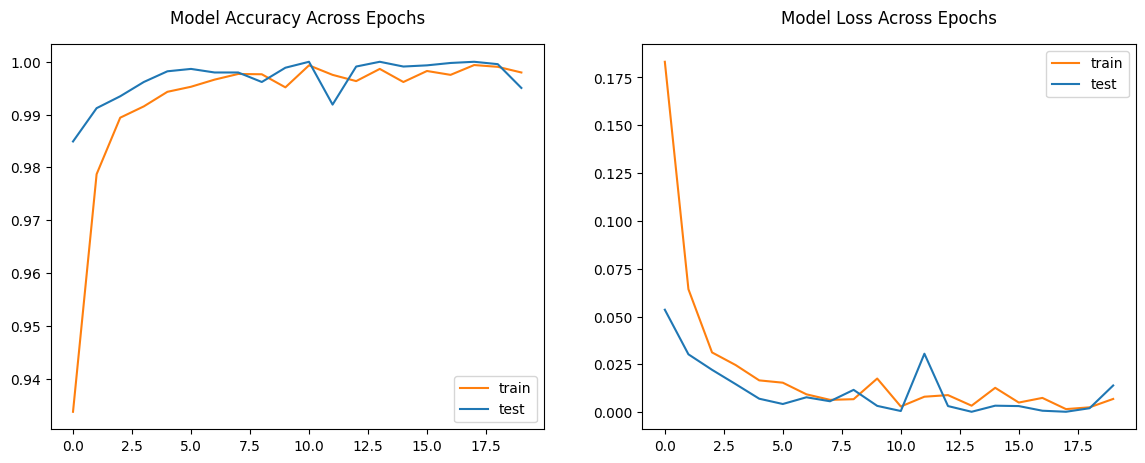

In [26]:
def plot_accuracy_loss(model_history):
    """Plot accuracy and loss for train and validation sets"""
    # Set fig
    f, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot model train accuracy and loss
    ax[0].plot(model_history.history['accuracy'],
               label='train', c='tab:orange')
    ax[1].plot(model_history.history['loss'], label='train', c='tab:orange')

    # Plot model test accuracy and loss
    try:
        if model_history.history['val_accuracy']:
            ax[0].plot(model_history.history['val_accuracy'],
                       label='test', c='tab:blue')
            ax[1].plot(model_history.history['val_loss'],
                       label='test', c='tab:blue')
    except KeyError:
        pass

    # Set plot elements
    ax[0].legend()
    ax[0].set_title('Model Accuracy Across Epochs', pad=15)
    ax[1].legend()
    ax[1].set_title('Model Loss Across Epochs', pad=15)


plot_accuracy_loss(augmented_hist)

# 12 or 13 epochs seems best for both computational performance and 
# accuracy/loss optimization

## CV2 Preprocessed Data

###  Plot Predictions

2022-11-14 21:39:50.759369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


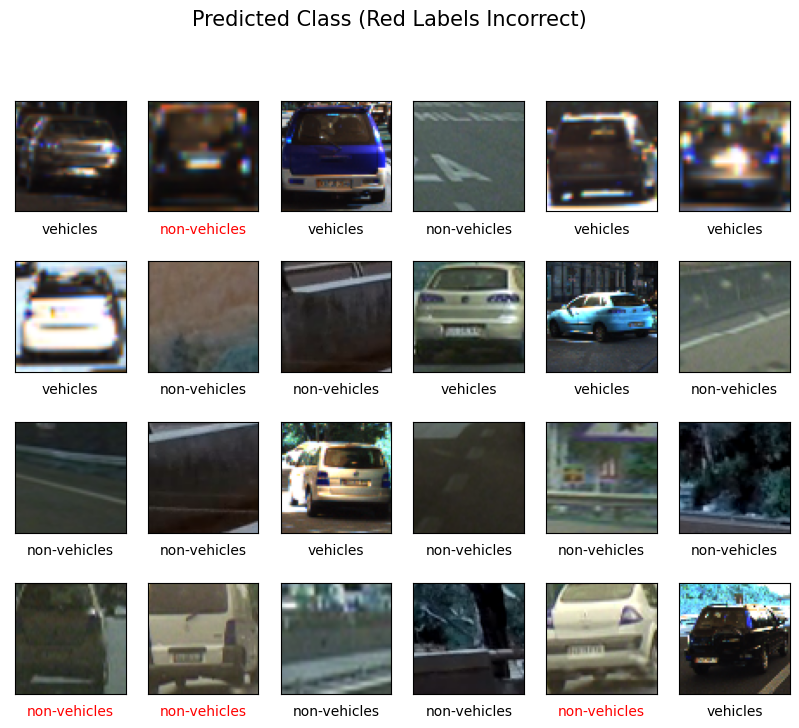

In [27]:
# Predict with CNN
y_fit_cv2 = keras_model2.predict(X_test)

# Convert value to int for classifying
yf_ = [int(i) for i in y_fit_cv2]

# Plot predictions
plot_predictions(X_test, y_test, yf_, 4, 6)

### Plot Accuracy and Loss

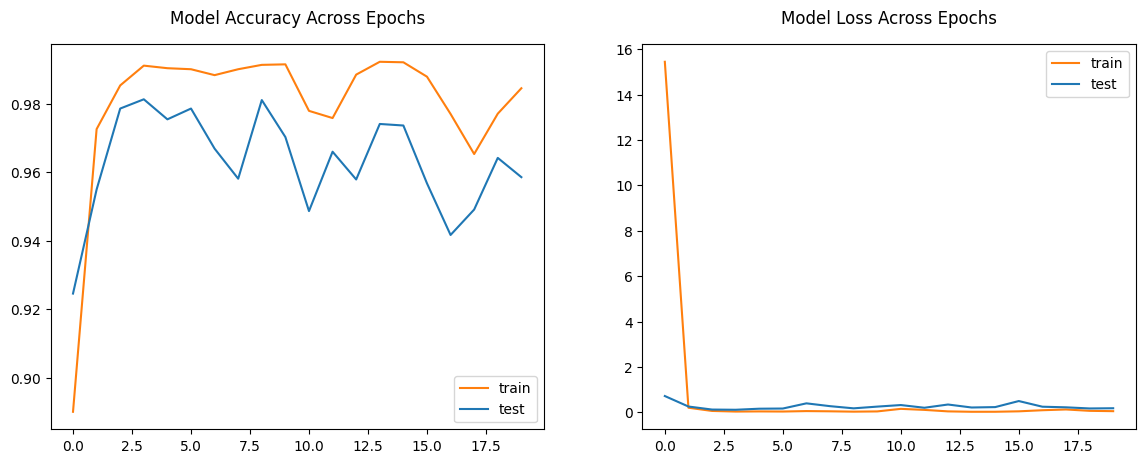

In [28]:
plot_accuracy_loss(standard_hist)

# Model with CV2 data performs worse than augmented model (train gens)

### Predict my Car with CNN

2022-11-14 21:39:57.432876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Predicted: Vehicle')

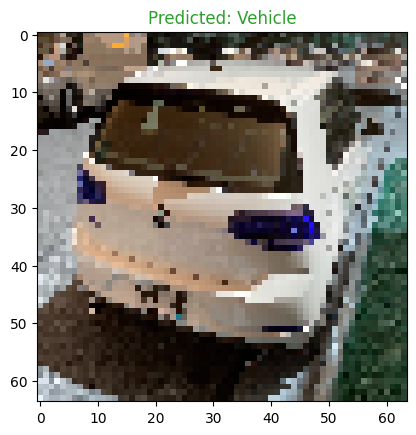

In [29]:
# Read in my car iphone image and resize for CNN compatability
vw = cv2.resize(cv2.imread('my_car.png'), (64, 64))

# Grab dimensions for reshaping
n, r, z = vw.shape

# Reshape and predict with CNN
pred = np.where(keras_model.predict(vw.reshape(1, n, r, z)) >= 1,
                'Vehicle', 'Non-Vehicle')[0][0]

# Plot
plt.imshow(vw)
plt.title(f'Predicted: {pred}', color=str(
    np.where(pred == 'Vehicle', 'tab:green', 'tab:red')));

# Keras model also predicts my vehicle correctly